## Import Libraries

In [1]:
%pip install yake
%pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import time
import json

from getpass import getpass
import httpx
import yake
from tqdm import tqdm
import matplotlib.pyplot as plt

## Setting up the API key variable

In [3]:
API_URL="https://api.dp.la/v2/"
ENV_VAR = "DPLA_API_KEY"
TIMEOUT=30.0
FALLBACK_DATA_URL = "https://raw.githubusercontent.com/UCSB-Library-Research-Data-Services/intro2APIs/refs/heads/main/data/"

In [4]:
key= os.getenv(ENV_VAR)

# This method avoids hardcoding the API key in the script
# The variable is persistent during the session
if not key:
    key = getpass(f"Enter your DPLA API key: ").strip()
    if not key:
        raise ValueError("No API key provided.")
    os.environ[ENV_VAR] = key
    
print(f"API key set in environment variable {ENV_VAR}.")

API key set in environment variable DPLA_API_KEY.


## Helping Functions

In [5]:
def _join_list(x, sep="; ", keep_first_only=False):
    if isinstance(x, list):
        if keep_first_only and len(x) > 0:
            return str(x[0])
        return sep.join(str(v) for v in x if v is not None)
    return "" if x is None else str(x)

In [6]:
def top_n(d, n=10):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=True)[:n])

In [ ]:
def redact_request_url(url):
    """Remove the api_key parameter from the URL for display purposes."""
    if "api_key=" in url:
        parts = url.split("api_key=")
        prefix = parts[0]
        suffix = parts[1].split("&", 1)[-1] if "&" in parts[1] else ""
        return f"{prefix}api_key=REDACTED&{suffix}" if suffix else f"{prefix}api_key=REDACTED"
    return url

In [ ]:
def search_items(query, resource_type='items', verbose=False, timeout=30.0, **parameters):
    """
    Search DPLA items with given query and parameters.
    
    Args:
        query (str): The search query string. It's possible to use logical operators 
        (AND, OR, NOT). Additionally, you can use wildcards (*) for partial matches.
        resource_type (str): The type of resource to search for. Default is 'items'.
        verbose (bool): If True, prints the request URL. Default is False.
        timeout (float): The timeout for the HTTP request in seconds. Default is 30.0.
        **parameters: Facets and filter parameters from the DPLA API documentation: https://pro.dp.la/developers/requests
                    Dotted keywords and values can be passed using dictionary unpacking. For example, to filter by sourceResource.title, you can pass:
                    **{"sourceResource.title": "example title"}
    Returns:
        dict: The JSON response from the DPLA API as a Python dictionary.
    """
    
    base_url = f"{API_URL}{resource_type}"
    params = {
        "q": query,
        "api_key": os.getenv(ENV_VAR),
    }
    
    # Add remaining parameters
    for key, value in parameters.items():
        params[key] = value
        
    # Make the request
    with httpx.Client(timeout=timeout) as client:
        response = client.get(base_url, params=params)
    
    print(f"Request URL: {response.url}") if verbose else None
    
    response.raise_for_status() 
    return response.json()

In [ ]:
def search_all_items(query, resource_type='items', max_items=100, sleep=0.5, verbose=False, timeout=30.0, **parameters):
    """
    Collect up to max_items across pages.
    
    Args:
        query (str): The search query string. It's possible to use logical operators 
            (AND, OR, NOT). Additionally, you can use wildcards (*) for partial matches.
        resource_type (str): The type of resource to search for. Default is 'items'.
        max_items (int): Maximum number of items to retrieve. For number of elements per page, 
            use the page_size parameter in **parameters.
        sleep (float): Time to wait between requests to avoid hitting rate limits.
        verbose (bool): If True, prints the request URL for each page. Default is False.
        timeout (float): The timeout for the HTTP request in seconds. Default is 30.0.
        **parameters: Facets and filter parameters from the DPLA API documentation: https://pro.dp.la/developers/requests
    """
    all_docs = []
    page = 1
    page_size = int(parameters.get("page_size", 100))
    if page_size > 100:
        page_size = 100
        print("page_size cannot exceed 100. Setting to 100.")
        
    while len(all_docs) < max_items:
        parameters['page'] = page
        data = search_items(query, resource_type=resource_type, verbose=verbose, timeout=timeout, **parameters)
        docs = data.get('docs', [])
        if not docs:
            break  # No more results
        all_docs.extend(docs)
        
        # stop if we've reached max_items
        if len(all_docs) >= max_items:
            break
        
        page += 1
        time.sleep(sleep)
        
    return all_docs[:max_items]

    

In [9]:

try:
    mysearch = search_items(
        "artificial AND intelligence", # search query
        facets="sourceResource.date.begin,sourceResource.date.end", # facets to include in the response
        page_size=20, # items per page
        sort_by="sourceResource.date.begin", # sort by date
        sort_order="asc", # oldest to newest
        page=1, # page number to retrieve
        verbose=True, # print the request URL for debugging purposes
        **{"sourceResource.subject.name": "artificial intelligence"} # filter to ensure results are about AI, not just using AI in metadata
        )
    
    # OPTIONAL: save the results to a local file for later use
    with open("../../data/dpla_search_results.json", "w") as f:
        json.dump(mysearch, f, indent=2, ensure_ascii=False)
    
except httpx.HTTPStatusError as e:
    print(f"HTTP error occurred: {e}. Using preloaded data instead.")
    r = httpx.get(f"{FALLBACK_DATA_URL}dpla_search_results.json")
    r.raise_for_status()
    mysearch = r.json()


# download the preloaded data for the next steps
print(f"{mysearch.get('count')} results found.") if isinstance(mysearch, dict) else print(f"{len(mysearch)} results found.")
print(f"Facets: {mysearch.get('facets')}") if isinstance(mysearch, dict) else None

Request URL: https://api.dp.la/v2/items?q=artificial+AND+intelligence&api_key=699260cc7c4417f8a89e0afce4a31baa&facets=sourceResource.date.begin%2CsourceResource.date.end&page_size=20&sort_by=sourceResource.date.begin&sort_order=asc&page=1&sourceResource.subject.name=artificial+intelligence
728 results found.
Facets: {'sourceResource.date.begin': {'_type': 'date_histogram', 'entries': [{'count': 4, 'time': '2026'}, {'count': 119, 'time': '2025'}, {'count': 95, 'time': '2024'}, {'count': 77, 'time': '2023'}, {'count': 23, 'time': '2022'}, {'count': 28, 'time': '2021'}, {'count': 30, 'time': '2020'}, {'count': 22, 'time': '2019'}, {'count': 12, 'time': '2018'}, {'count': 2, 'time': '2017'}, {'count': 4, 'time': '2016'}, {'count': 6, 'time': '2015'}, {'count': 3, 'time': '2014'}, {'count': 2, 'time': '2013'}, {'count': 2, 'time': '2012'}, {'count': 1, 'time': '2011'}, {'count': 1, 'time': '2010'}, {'count': 1, 'time': '2007'}, {'count': 1, 'time': '2004'}, {'count': 3, 'time': '2001'}, {'c

## Let's play with the faceted elements

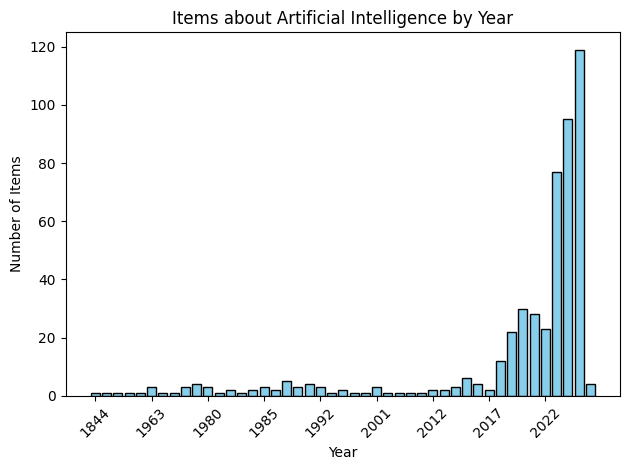

In [10]:
# Visualize the histogram of entries dates

facets_list = mysearch.get('facets').get('sourceResource.date.begin').get('entries')

years = [d['time'] for d in facets_list][::-1] # We use [::-1] to reverse the order
counts = [d['count'] for d in facets_list][::-1]

plt.bar(years, counts, color='skyblue', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of Items')
plt.title('Items about Artificial Intelligence by Year')
plt.xticks(range(0, len(years), 5), [years[i] for i in range(0, len(years), 5)], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
periods = [
    ("preCovid", 1844, 2018),
    ("Covid", 2019, 2021),
    ("postCovid", 2022, 2026),
]

In [21]:
# create a pool of results for each period
ai_results = {}

try:
    for period_name, start_date, end_date in tqdm(periods):
        print(f"Searching for AI items in the {period_name}: {start_date} to {end_date}")
        ai_results[period_name] = search_all_items(
            "artificial AND intelligence", # search query
            max_items=3000, # maximum number of items to retrieve for each period
            facets="sourceResource.date.begin,sourceResource.date.end", # Retrieve facets for date ranges
            page_size=50, # items per page
            **{"sourceResource.subject.name": "artificial intelligence"}, # filter to ensure results are about AI, not just using AI in metadata
            **{"sourceResource.date.after": str(start_date)}, # Between year
            **{"sourceResource.date.before": str(end_date)}, # and Year
            sort_by="sourceResource.date.begin", # sort by date
            sort_order="asc", # oldest to newest
            verbose=False 
        )
        print(f"Found {len(ai_results[period_name])} items for period {period_name}.\n")
        
    # OPTIONAL: save the results to a local file for later use
    with open("../../data/ai_results_by_wave.json", "w") as f:
        json.dump(ai_results, f, indent=2, ensure_ascii=False)
        
except httpx.HTTPStatusError as e:
    print(f"HTTP error occurred: {e}. Using preloaded data instead.")
    r = httpx.get(f"{FALLBACK_DATA_URL}ai_results_by_wave.json")
    r.raise_for_status()
    ai_results = r.json()
    for period_name in ai_results:
        print(f"Loaded {len(ai_results[period_name])} items for period {period_name} from preloaded data.\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Searching for AI items in the preCovid: 1844 to 2019


 33%|███▎      | 1/3 [00:03<00:07,  3.85s/it]

Found 110 items for period preCovid.

Searching for AI items in the Covid: 2019 to 2022


 67%|██████▋   | 2/3 [00:07<00:03,  3.47s/it]

Found 103 items for period Covid.

Searching for AI items in the postCovid: 2022 to 2026


100%|██████████| 3/3 [00:18<00:00,  6.08s/it]

Found 318 items for period postCovid.



In [22]:
ai_results_summary = {period: len(items) for period, items in ai_results.items()}
print("AI Results Summary by Period:")
for period, count in ai_results_summary.items():
    print(f"{period}: {count} items")

AI Results Summary by Period:
preCovid: 110 items
Covid: 103 items
postCovid: 318 items


In [24]:
ai_results['preCovid'][50].get('sourceResource')

{'@id': 'http://dp.la/api/items/a52c29d501ad48bcd0d8d387e8b15935#SourceResource',
 'contributor': ['Defense Security Institute (U.S.)'],
 'date': [{'begin': '1998', 'displayDate': '1998', 'end': '1998'}],
 'description': ['"OASD-PA/98-5-2028"--P. 25.',
  'Shipping list no.: 98-0316-P.',
  'Cover title.'],
 'extent': ['25 p. : 28 cm.'],
 'format': ['Language material', 'Electronic resource'],
 'identifier': ['sdr-uiuc4072096', '(OCoLC)39685049', 'Hathi: 011396929'],
 'language': [{'iso639_3': 'English', 'name': 'English'}],
 'publisher': ['[Washington, D.C. : Defense Security Service]'],
 'rights': ['Public domain. Learn more at http://www.hathitrust.org/access_use'],
 'spatial': [{'name': 'United States'}],
 'subject': [{'name': 'Technology transfer--United States'},
  {'name': 'Artificial intelligence--Military applications'}],
 'title': ['Technology collection trends in the US defense industry, 1998'],
 'type': ['text']}

In [25]:
ai_results['preCovid'][50].get('sourceResource').get('subject')[1].get('name')

'Artificial intelligence--Military applications'

In [32]:
ai_keywords = {}

kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=5)

skip_bigrams = ["artificial intelligence"]

for period, items in tqdm(ai_results.items()):
    period_keywords = {}
    for item in items:
        source_res = item.get('sourceResource', {})
        title = _join_list(source_res.get('title', ''), keep_first_only=True)
        description = _join_list(source_res.get('description', ''), keep_first_only=True)
        text = f"{title} {description}".lower()
        
        keywords = kw_extractor.extract_keywords(text)
        for kw, score in keywords:
            if kw in skip_bigrams:
                continue
            period_keywords[kw] = period_keywords.get(kw, 0) + 1
            
    ai_keywords[period] = period_keywords

100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


In [33]:
top = 10

for period, keywords in ai_keywords.items():
    sorted_keywords = sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:top]
    print(f"Top {top} keywords for {period}:")
    for kw, count in sorted_keywords:
        print(f"  {kw}: {count}")
    print()

Top 10 keywords for preCovid:
  artificial: 7
  united states: 7
  bibliographical references: 6
  intelligence: 5
  machine intelligence: 5
  includes bibliographical: 5
  final report: 5
  machine learning: 5
  states senate: 5
  national security: 5

Top 10 keywords for Covid:
  sixteenth congress: 14
  financial services: 10
  national security: 8
  united states: 8
  states senate: 8
  armed services: 7
  machine learning: 7
  hundred sixteenth: 6
  september: 5
  governmental affairs: 5

Top 10 keywords for postCovid:
  indexing program: 55
  united states: 51
  library program: 43
  states senate: 42
  eighteenth congress: 37
  government publishing: 32
  updated irregularly: 30
  machine learning: 21
  governmental affairs: 16
  artificial: 14



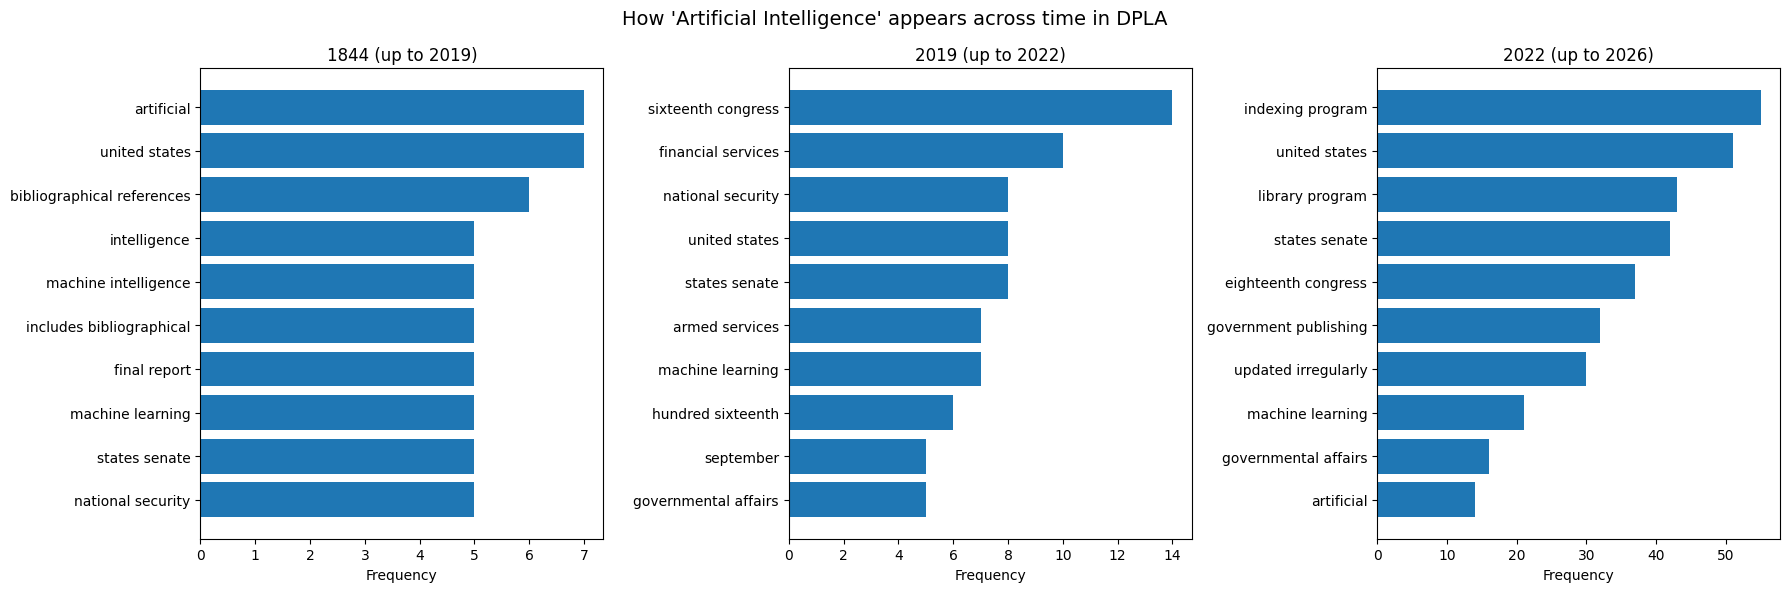

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

for ax, (period_name, start_year, end_year) in zip(axes, periods):
    data = top_n(ai_keywords.get(period_name, {}), 10)
    terms = list(data.keys())[::-1]
    counts = list(data.values())[::-1]

    ax.barh(terms, counts)
    ax.set_title(f"{period_name} ({start_year}–{end_year})")
    ax.set_xlabel("Frequency")

plt.suptitle("How 'Artificial Intelligence' appears across time in DPLA", fontsize=14)
plt.tight_layout()
plt.show()